                      "Hand sign recognition by skeletonization (Structural methods)"     
                            --    Work done by : assia855 & AElghebouli    --  

In [1]:
#Libraries
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
import os
from skimage.morphology import skeletonize
from skimage import measure
from os import listdir 
from os.path import isfile, join 
from fil_finder import FilFinder2D
import astropy.units as u

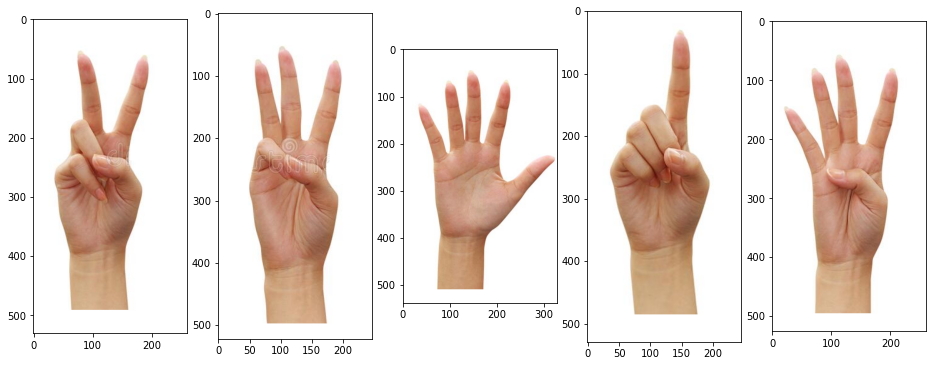

In [2]:
## Reading images from a folder
mypath=  os.path.realpath('Images')
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
Img = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
    if onlyfiles[n].split('.')[-1] == 'png':
        Img[n] = cv2.imread(join(mypath,onlyfiles[n])) 
        Img[n] = cv2.cvtColor(Img[n], cv2.COLOR_BGR2RGB) # convert BGR to RGB 

#show the images  
plt.figure(figsize=(16,12))
for i in range(len(Img)):
    plt.subplot(1,5,i+1)
    plt.imshow(Img[i])

## Pre-processing

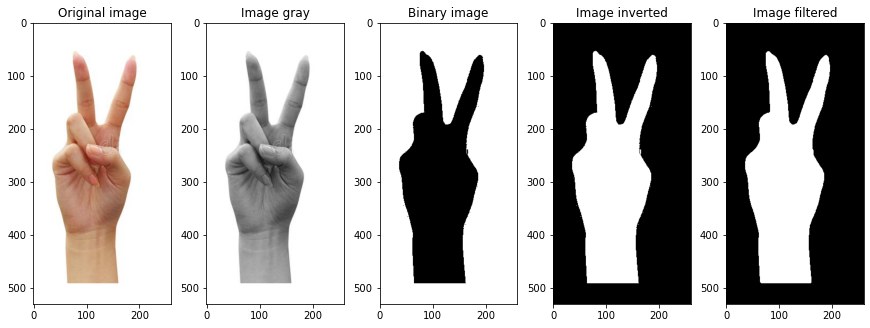

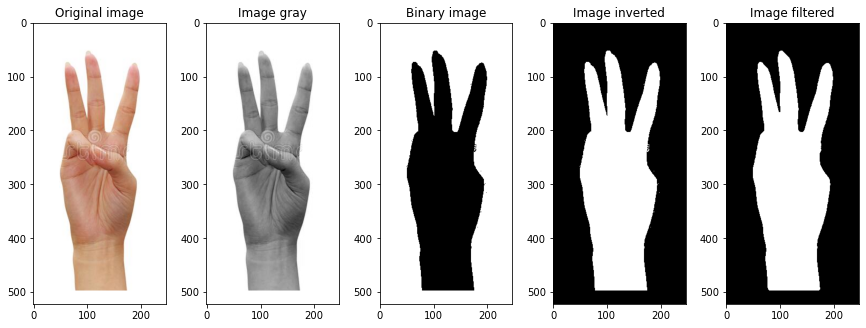

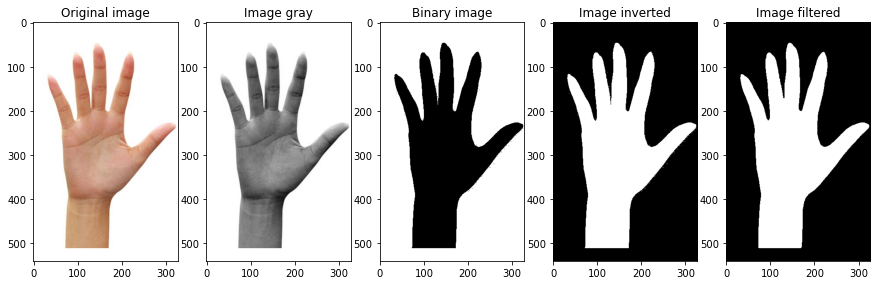

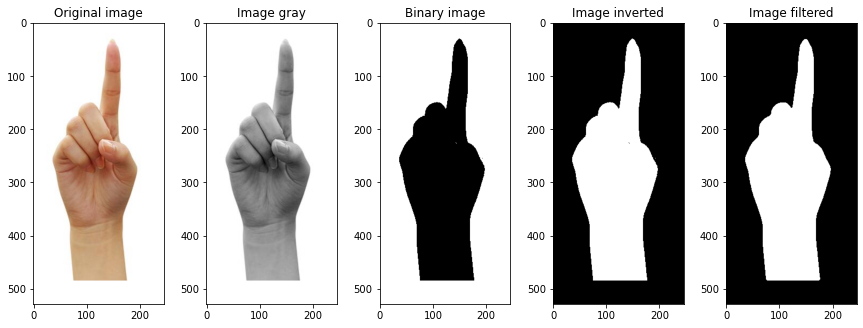

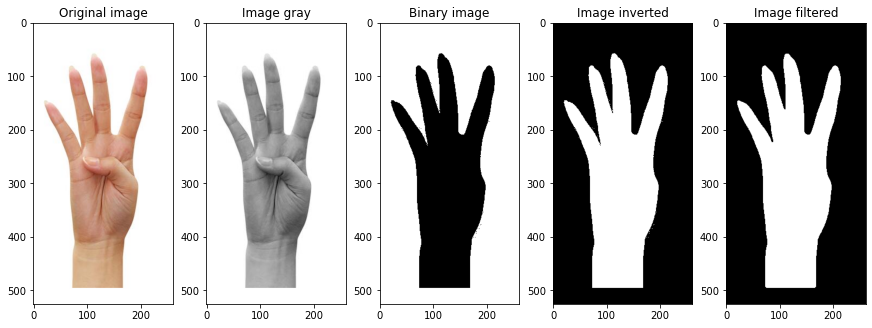

In [3]:
DST = []
for i in range(len(Img)):
    j = i*5
    ## Original image
    img= Img[i]

    plt.figure(figsize=(15,30))
    plt.subplot(5,5,j+1)
    plt.imshow(img) 
    plt.title('Original image')

    ## Convert to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(5,5,j+2)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Image gray')

    ## Convert to binary with threshold 245
    ret,imgBW = cv2.threshold(img_gray ,245,255,0)
    plt.subplot(5,5,j+3)
    plt.imshow(imgBW, cmap='gray')
    plt.title('Binary image')

    ## Image inverted
    imgBW[:,:] = abs(imgBW[:,:] - 255)
    plt.subplot(5,5,j+4)
    plt.imshow(imgBW, cmap='gray')
    plt.title('Image inverted')

    ## Median filter to remove noise
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(imgBW,-1,kernel)
    DST.append(dst)
    plt.subplot(5,5,j+5)
    plt.imshow(dst, cmap='gray')
    plt.title('Image filtered')
    plt.show()

## Skeletonization

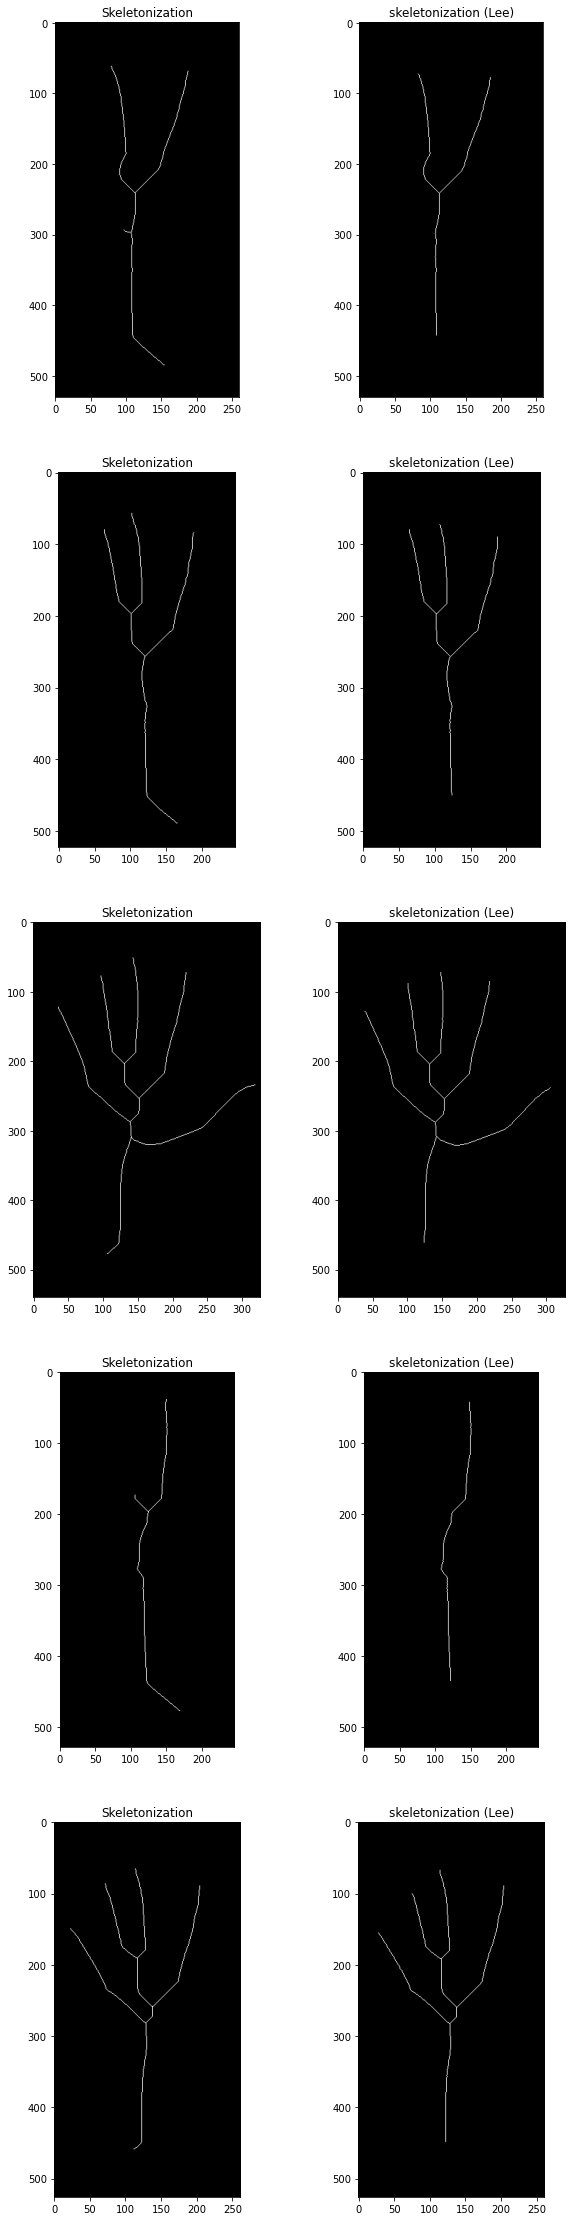

In [4]:
#skeletonization of binary image
SKELTON = []
SKELTON_LEE = []
plt.figure(figsize=(10,40))
for i in range(len(Img)):
    j = i*2
    skeleton = skeletonize(DST[i]) 
    SKELTON.append(skeleton)
    ''' Apply a mask on the image that iterate around the image pixels and allocate each pixel a value from 0 to 255 by removing 
    all the pixels around the region of interest borders and continue the  iteration until no pixel on borders are detected. '''

    skeleton_lee = skeletonize(DST[i], method='lee')
    SKELTON_LEE.append(skeleton_lee)
    ''' Works with octree data structure to examine a 3x3x3 neighborhood of a pixel. The algorithm iterate around 
    all the image pixels until no change is detected.(Delaunay) '''

    plt.subplot(5,2,j+1)
    plt.imshow(skeleton, 'gray') 
    plt.title('Skeletonization')

    plt.subplot(5,2,j+2)
    plt.imshow(skeleton_lee, 'gray') 
    plt.title('skeletonization (Lee)')
plt.show()

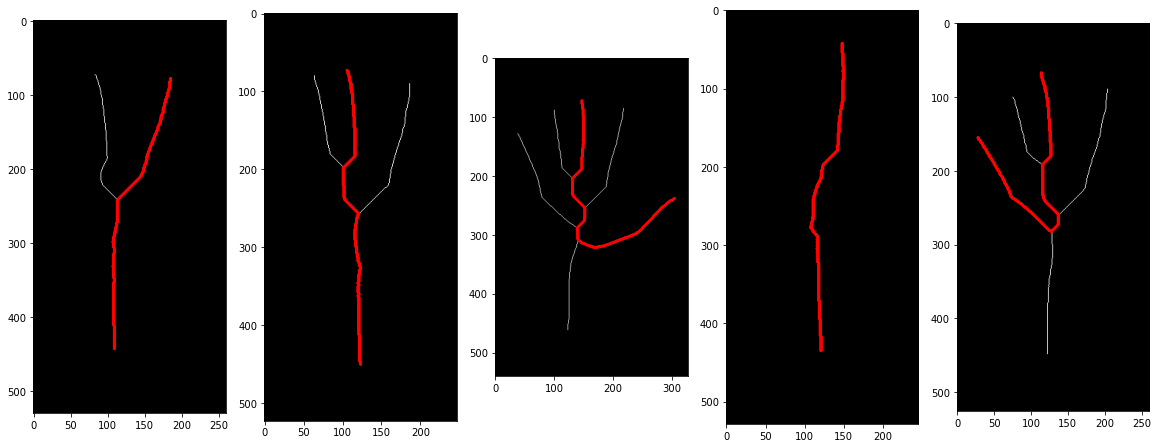

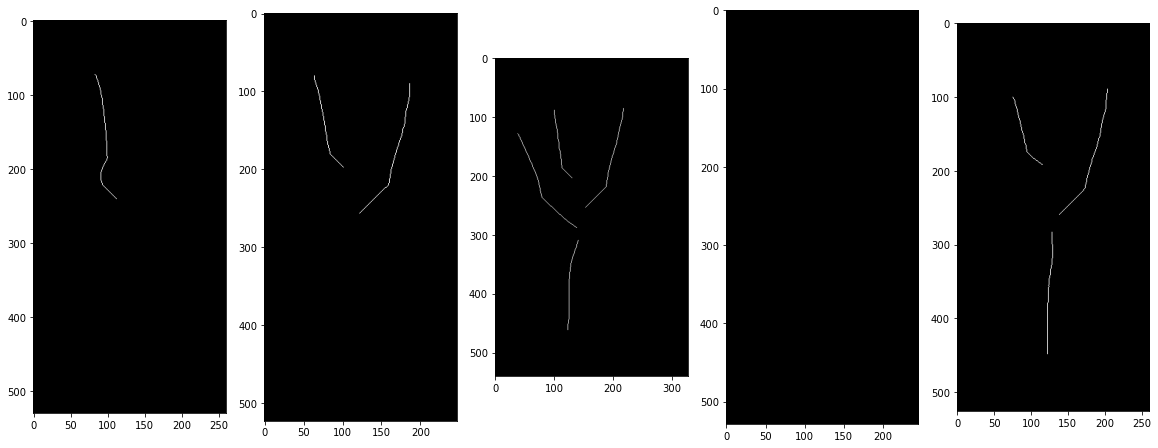

In [6]:
## Length measurement

I_3 = []
MAX_LAB = []
plt.figure(1, figsize=(20,15))
for i in range(len(Img)): 
    skeleton = SKELTON_LEE[i]
    '''astropy. units is a Python package to handle defining and converting between physical units,
    and performing arithmetic with physical quantities (numbers with associated units).
    fil_finder the algorithm is capable of uniformly extracting structure over a large dynamical range in intensity.'''

    fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
    # fil.preprocess_image(flatten_percent=1)
    fil.create_mask(border_masking=True, verbose=False,use_existing_mask=True)
    fil.medskel(verbose=False)
    fil.analyze_skeletons(branch_thresh=1*u.pix, skel_thresh=1 * u.pix, prune_criteria='length')
    
    # Substraction of the longest branch
    I1 = fil.skeleton
    I2= fil.skeleton_longpath
    I3 = I1 - I2
    I_3.append(I3)
    
    # Compute the branch number(how many branch we have in the image)
    I3_inv = abs(I_3[i][:,:] - 255)
    labels_inv = measure.label(I3_inv)
    max_lab_inv = labels_inv.max()
    labels = measure.label(I_3[i])
    MAX_LAB.append(labels.max())
    
    plt.subplot(1, 5, i+1)
    # Show the longest path
    plt.imshow(fil.skeleton, cmap='gray')
    plt.contour(fil.skeleton_longpath, colors='r')
plt.show()

plt.figure(2, figsize=(20,15))
for i in range(len(Img)): 
    plt.subplot(1, 5, i+1)
    plt.imshow(I_3[i],'gray')
plt.show()

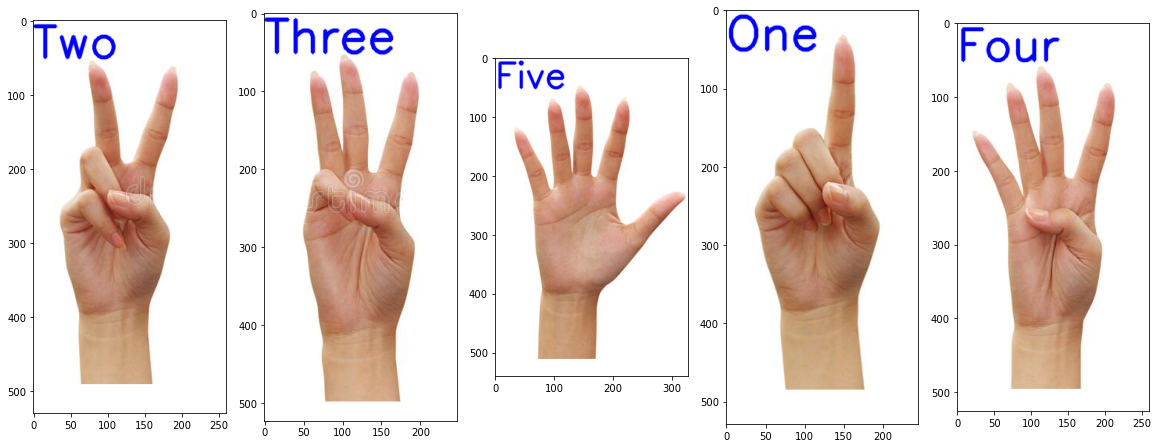

In [7]:
## Make conditions to identify and visualize the hand signs

texts = ['One', 'Two', 'Three','Four','Five']
font = cv2.FONT_HERSHEY_SIMPLEX
max_lab = MAX_LAB + np.ones((len(I_3)))

for i in range(len(I_3)):
    if max_lab[i] == 1:
        cv2.putText(Img[i], "One", (0, 50), font, 2, (0, 0, 255), 3, cv2.LINE_AA, False)

    elif max_lab[i] == 2:
        cv2.putText(Img[i], "Two", (0, 50), font, 2, (0, 0, 255), 3, cv2.LINE_AA, False)

    elif max_lab[i] == 3:
        cv2.putText(Img[i], "Three", (0, 50), font, 2, (0, 0, 255), 3, cv2.LINE_AA, False)

    elif  max_lab[i] == 4:
        cv2.putText(Img[i], "Four", (0, 50), font, 2, (0, 0, 255), 3, cv2.LINE_AA, False)

    elif  max_lab[i] == 5:
        cv2.putText(Img[i], "Five", (0, 50), font, 2, (0, 0, 255), 3, cv2.LINE_AA, False)
    
  
 #show the result
plt.figure(figsize=(20,15))
for i in range(len(Img)): 
    plt.subplot(1, 5, i+1)
    plt.imshow(Img[i])
plt.show()
